# PVInspect Defect Pipeline

This exemplarily demonstrates how several components from PVInspect can be combined to set up a complete defect analysis pipeline.

%load_ext autoreload
%autoreload 2

The `analysis` module requires `pytorch_lightning` and `albumentations` to be installed:

In [1]:
%%capture
!pip install --upgrade pytorch_lightning~=1.0 albumentations~=1.0

In [2]:
import pvinspect as pv
from pvinspect import preproc
from pathlib import Path
from pvinspect import analysis

For this example, we've prepared a single image showing two modules at once. We now want to locate the modules, segment them into cells and run our a weakly supervised defect detection on the resulting cell images.

Let's get started and download the sample image:

In [3]:
!gdown --id 1kJPYct8AqmgzV1xIBWX47NnfTCtut4eJ

/Users/z003v8ys/dev/pvinspect/.venv/lib/python3.10/site-packages/gdown/cli.py:126: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1kJPYct8AqmgzV1xIBWX47NnfTCtut4eJ
To: /Users/z003v8ys/dev/pvinspect/examples/multi_example.tif
100%|██████████████████████████████████████| 2.07M/2.07M [00:00<00:00, 6.89MB/s]


In [4]:
img = pv.data.io.read_image(Path("multi_example.tif"))

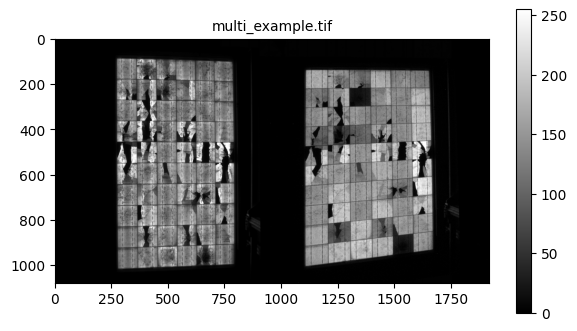

In [5]:
img.show(figscale=7)

## Multi module detection

Next, we run the built-in detection of multiple modules to coarsely locate the modules:

In [6]:
modules = preproc.detection.locate_multiple_modules(img)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 24.44it/s]


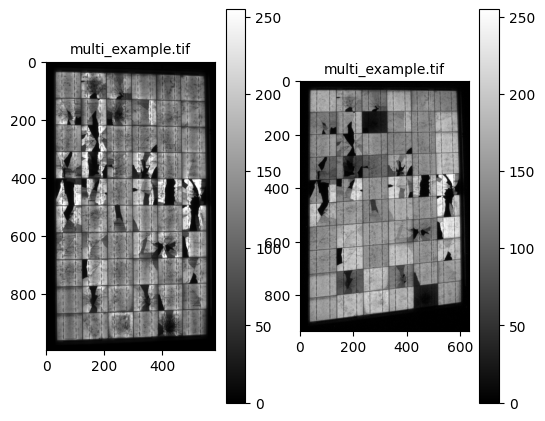

In [7]:
modules.head()

## Module segmentation

Before we can segment the module into single cells, we need to precisely locate the cell crossing points. Here we need to turn of the estimation of lens distortion, since this assumes that images come from the same camera and share a common lens distorion. This does not hold, since the module images are cropped out of a larger image. If you're still interested in distortion correction, you may want to use the calibration and compensation methods available in the `pvinspect.preproc.calibration` package.

In [8]:
modules = preproc.detection.locate_module_and_cells(modules, rows=6, cols=10, estimate_distortion=False)

100%|██████████| 2/2 [00:00<00:00, 15.13it/s]


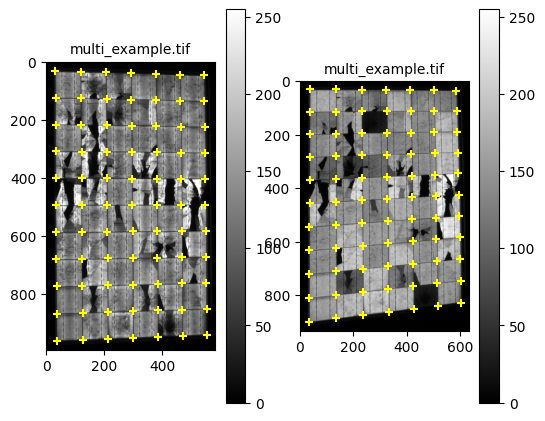

In [9]:
modules.head()

With the cell crossing points detected, we're now able to segment the modules into single cells:

In [10]:
cells = preproc.detection.segment_cells(modules)
len(cells)

100%|██████████| 2/2 [00:00<00:00,  9.43it/s]


120

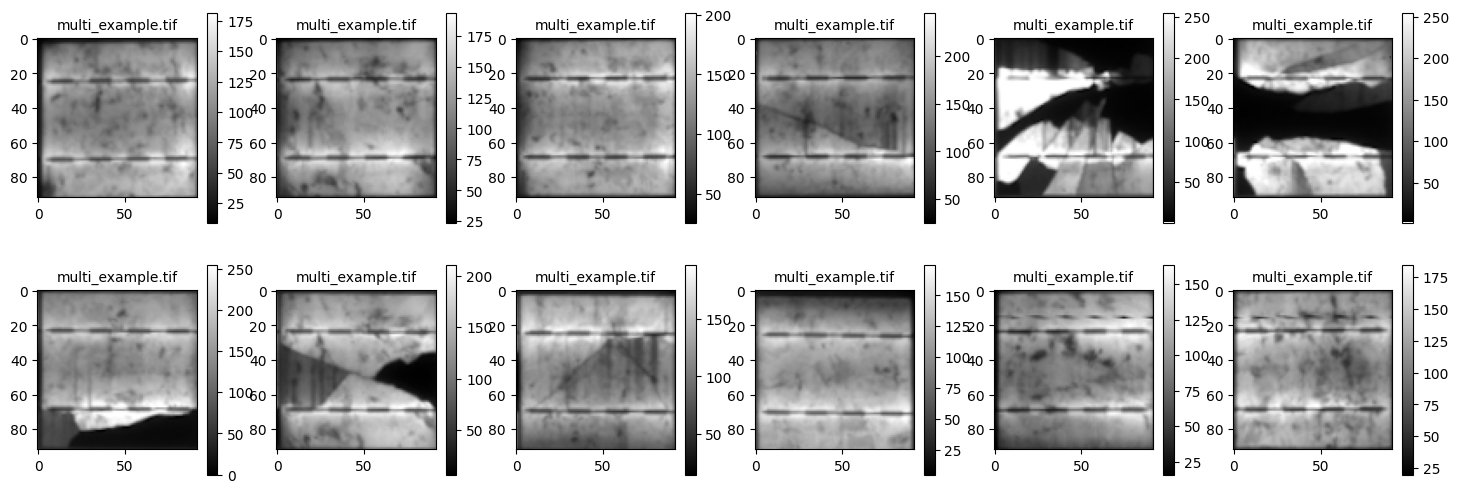

In [11]:
cells.head(N=12, cols=6)

## Defect detection

For defect detection, we first load the model that comes pretrained with the toolbox. Note that it may be necessary to fine-tune the module for a new dataset, especially when a new module type is introduced that has not been present during training.

In [12]:
model = analysis.factory_models.defects(use_cuda=False)

/Users/z003v8ys/dev/pvinspect/.venv/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:195: PossibleUserWarning: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
  rank_zero_warn(
Lightning automatically upgraded your loaded checkpoint from v1.1.2 to v1.9.5. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../pvinspect/analysis/factory_models/20210817_defects/model.ckpt`


/Users/z003v8ys/dev/pvinspect/pvinspect/analysis/factory_models/20210817_defects


/Users/z003v8ys/dev/pvinspect/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/z003v8ys/dev/pvinspect/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Now, we can directly apply the model to the cell images:

In [13]:
cells = model.apply(cells)

100%|██████████| 120/120 [00:05<00:00, 21.69it/s]


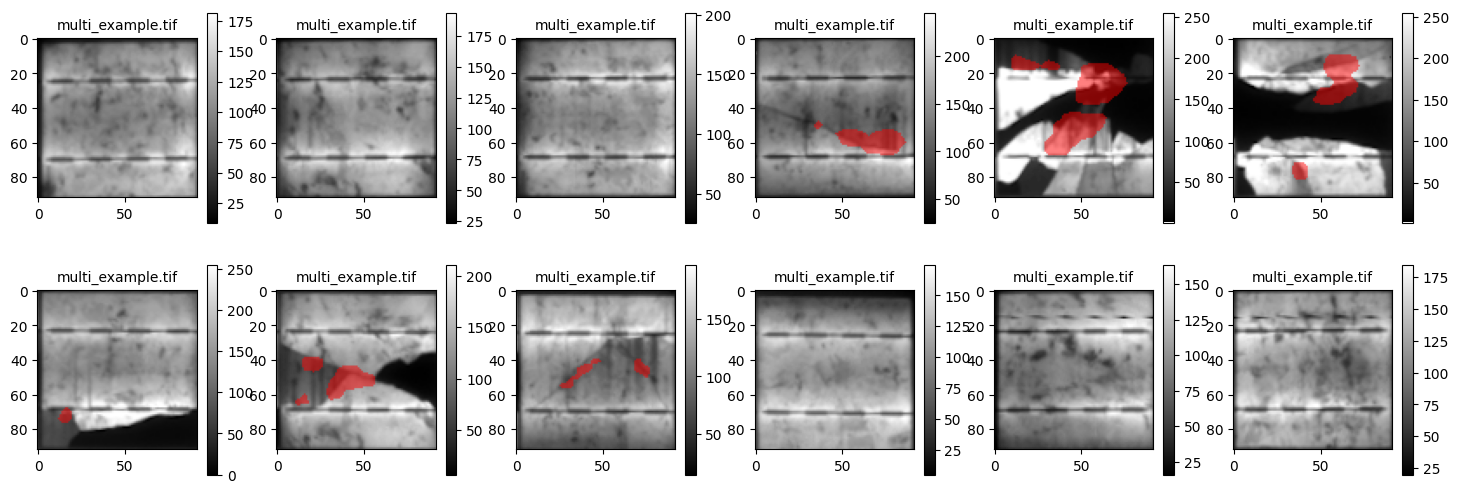

In [14]:
cells.head(N=12, cols=6)

This gives possible defective areas as an overlay. For this data, it works to some extend, although it misses parts of the defective area. The results are also stored in the meta data:

In [15]:
cells.meta.head()

,original_filename,multimodule_original,transform,rows,cols,first_col,first_row,segment_module_original,row,col,pred_crack_p,pred_inactive_p,pred_crack_cam,pred_inactive_cam
0,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,0,0,<pvinspect.data.image.image.EagerImage object ...,0,0,0.007268,0.000805,"[[0.00011662917, 5.447409e-05, 9.682847e-05, 7...","[[3.627975e-05, 1.1847488e-05, 1.4546586e-05, ..."
1,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,1,0,<pvinspect.data.image.image.EagerImage object ...,0,1,0.004032,0.000211,"[[0.00018712088, 9.502774e-05, 0.00016161852, ...","[[5.853017e-05, 1.6056818e-05, 3.4534583e-05, ..."
2,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,2,0,<pvinspect.data.image.image.EagerImage object ...,0,2,0.008916,0.000255,"[[0.00016730557, 6.2033636e-05, 0.00010675657,...","[[5.7694113e-05, 6.6954935e-06, 1.5885546e-05,..."
3,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,3,0,<pvinspect.data.image.image.EagerImage object ...,0,3,0.999743,0.000145,"[[3.6751768e-05, 5.1739567e-05, 8.29192e-05, 6...","[[1.2978445e-05, 8.512476e-06, 7.507428e-06, 7..."
4,multi_example.tif,<pvinspect.data.image.image.EagerImage object ...,None,1,1,4,0,<pvinspect.data.image.image.EagerImage object ...,0,4,1.000000,0.999998,"[[0.00019694377, 3.178736e-05, 2.536792e-05, 2...","[[3.0759547e-05, 2.781876e-06, 3.328763e-06, 5..."


For example, we can now filter by the crack probability:

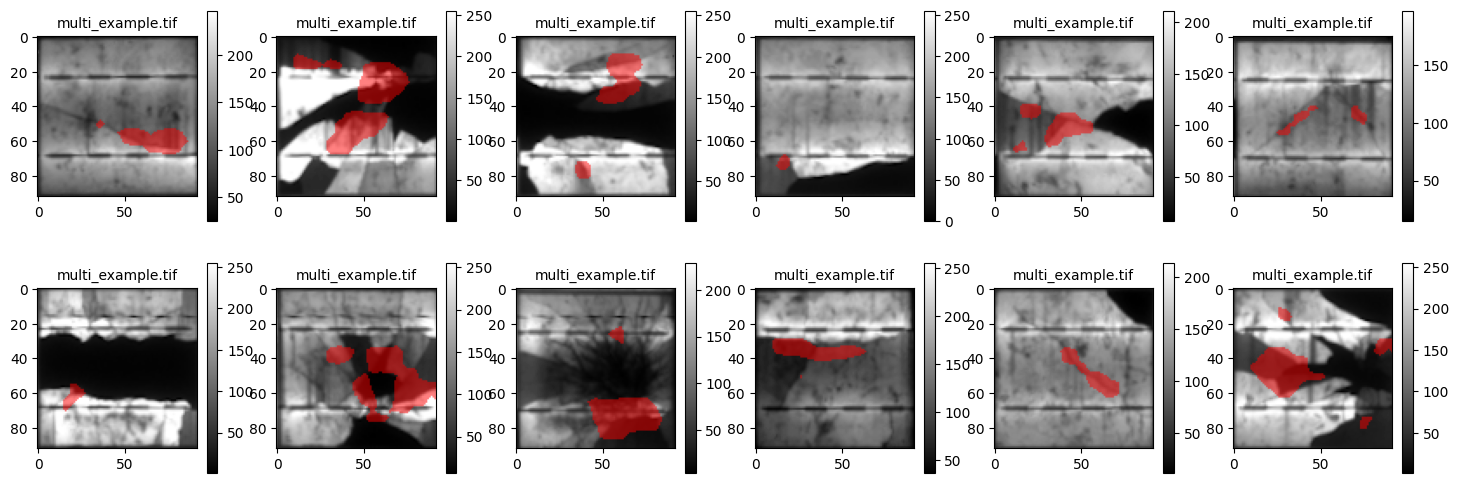

In [16]:
cells.pandas.query("pred_crack_p > 0.5").head(N=12, cols=6)

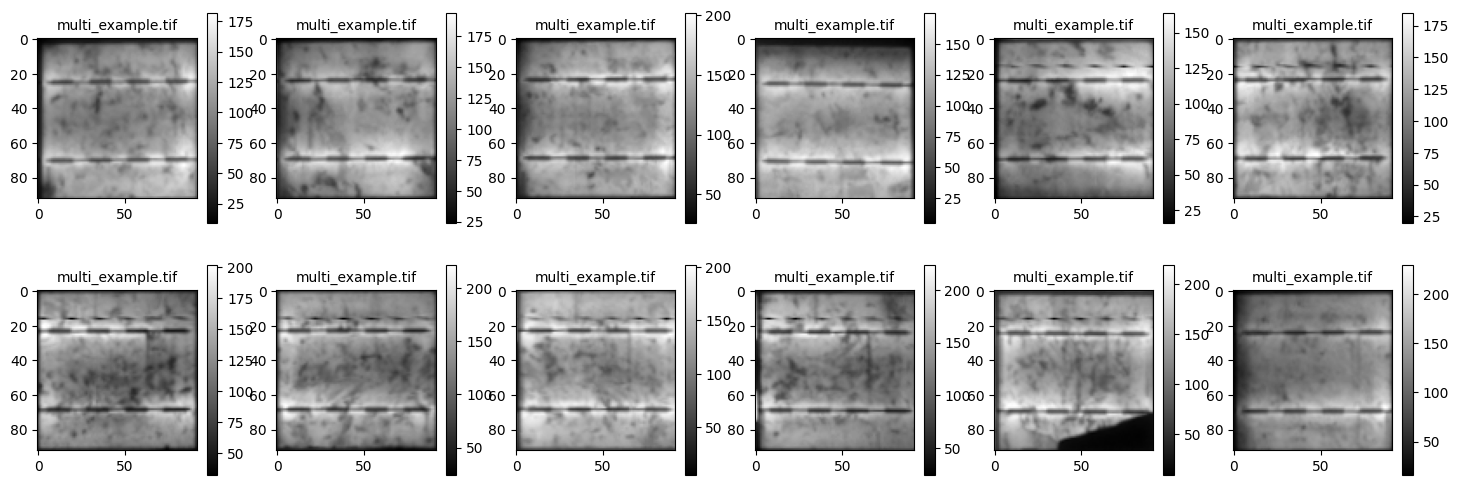

In [17]:
cells.pandas.query("pred_crack_p < 0.5").head(N=12, cols=6)

## Analysis

Through the built-in meta data, PVInspect also keeps track of what has happend to a certain image. Let's for example, pick some image with a crack found:

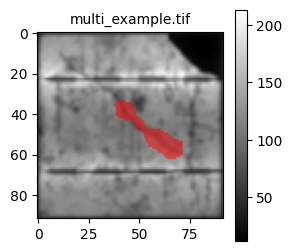

In [18]:
example_cell = cells.pandas.query("pred_crack_p > 0.5")[10]
example_cell.show()

From the multimodule detection, we have the image this module originates from available through the `multimodule_original` meta property:

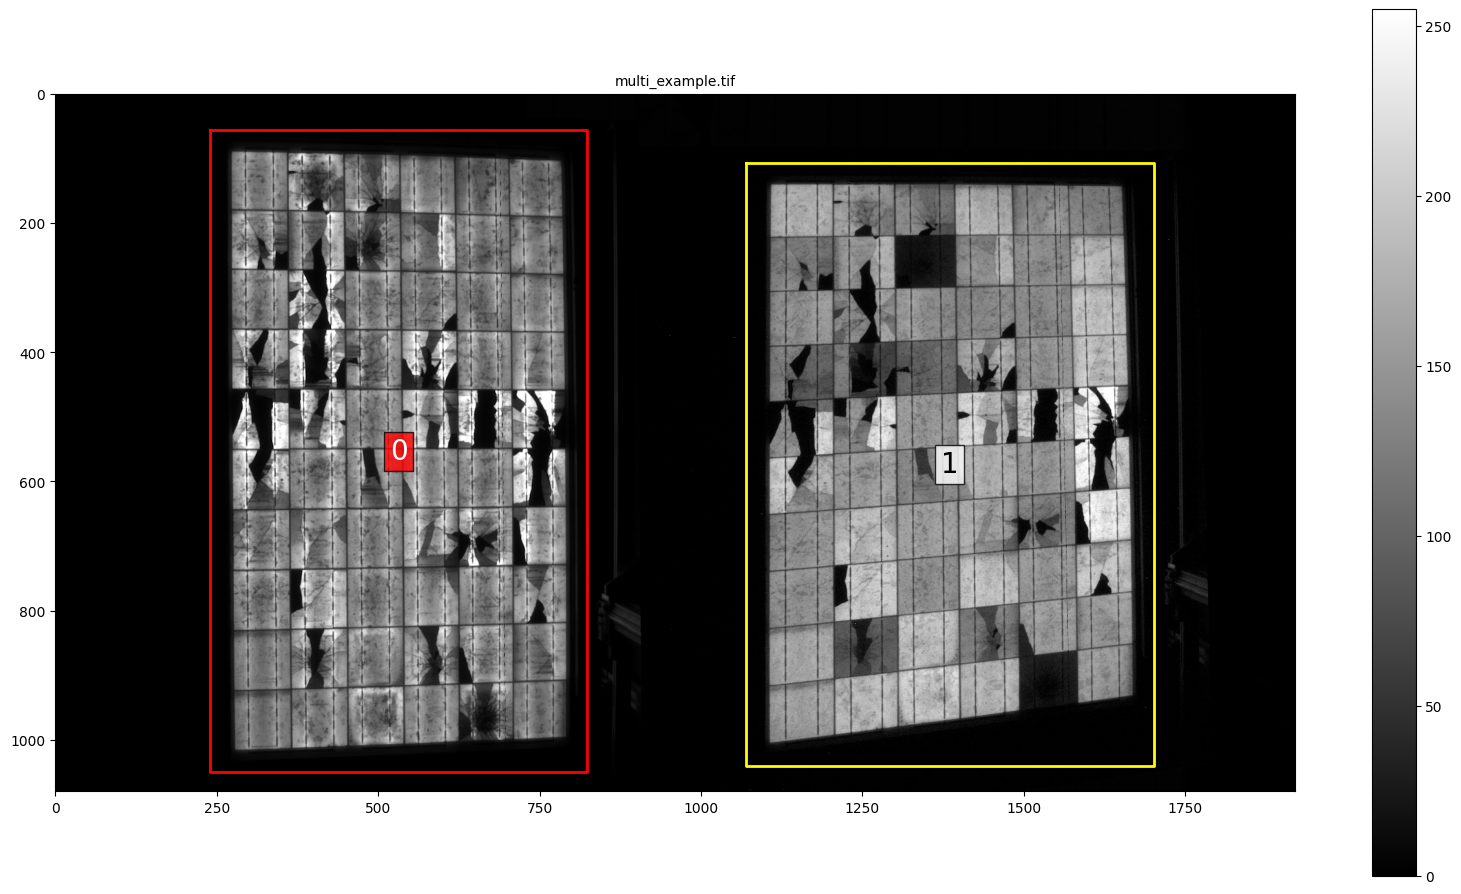

In [19]:
example_cell.get_meta("multimodule_original").show(figscale=20)

Furthermore, from the cell segmentation, we have the row and column index:

In [20]:
[example_cell.get_meta("row"), example_cell.get_meta("col")]

[2, 2]

Since the module detection asserts modules to be horizontally aligned (we specified that it has 10 columns, not rows!), we know that the cell at `(0, 0)` is the one on the top right of the left module image (highlighted in red). Thus, we can easily find the corresponding cell to `example_cell` in the module image.